## MFCC tutorial

In [1]:
import numpy as np
import scipy.io.wavfile
from scipy.fftpack import dct
import matplotlib.pyplot as plt

### Get the signal

In [2]:
file_path = 'audio_data/harvard_speech/OSR_us_000_0011_8k.wav'
sample_rate, signal = scipy.io.wavfile.read(file_path)

## get only the first 3.5 secondes of the signal
signal = signal[0: int(3.5 * sample_rate)]

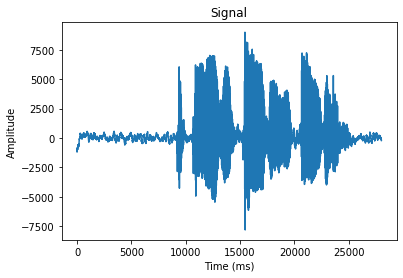

In [3]:
## plot the signal
plt.title('Signal')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.plot(signal)
plt.show()

### Pre-emphasis (amplify the high frequencies)


In [4]:
## set alpha coefficient
pre_emphasis = 0.97
emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

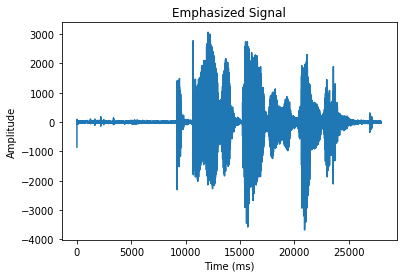

In [5]:
## plot the signal
plt.title('Emphasized Signal')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.plot(emphasized_signal)
plt.show()

### Framing (split the signal into short-time frames)

In [6]:
## set the frame size (25 ms)
frame_size = 0.025
## set the frame strides (10 ms)
frame_stride = 0.01

In [7]:
frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate
signal_length = len(emphasized_signal)
frame_length = int(round(frame_length))
num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame
pad_signal_len = num_frames * frame_step + frame_length
z = np.zeros((int(pad_signal_len - signal_length)))
# Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal
pad_signal = np.append(emphasized_signal, z)
indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(np.int32, copy=False)]

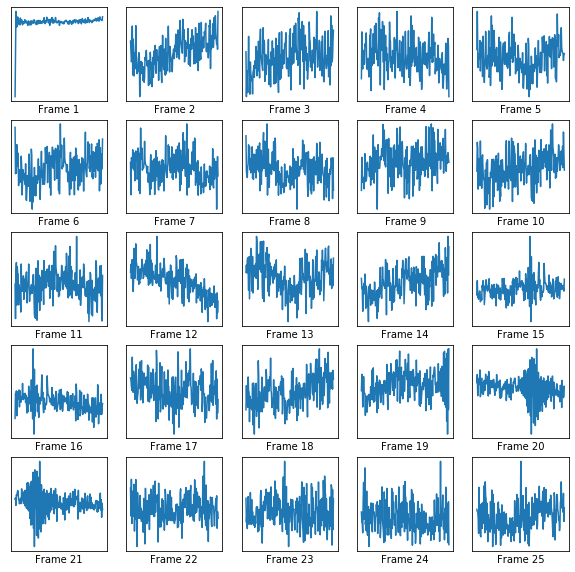

In [8]:
## plot the frames
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.xlabel('Frame ' + str(i + 1))
    plt.plot(frames[i])
plt.show()

### Window (apply function window on each frame)

#### Hamming window

In [9]:
def hamming(frame_length):
    '''
    => frames *= 0.54 - 0.46 * numpy.cos((2 * numpy.pi * n) / (frame_length - 1))
    => n varies from [0 to N - 1]
    '''
    new_vect = np.zeros(frame_length)
    for n in range(frame_length):
        new_vect[n] = 0.54 - 0.46 * np.cos((2 * np.pi * n) / (frame_length - 1))
    return new_vect

In [10]:
w = hamming(frame_length)

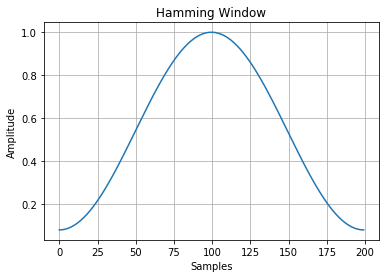

In [11]:
## plot the signal
plt.title('Hamming Window')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.plot(w)
plt.grid(True)
plt.show()

In [12]:
frames *= np.hamming(frame_length)

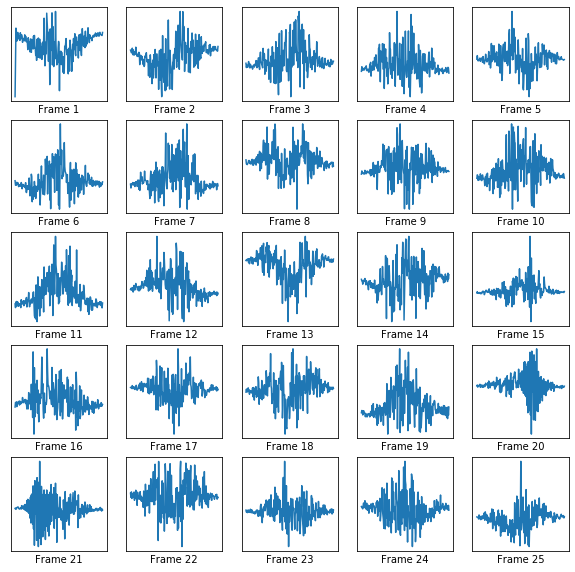

In [13]:
## plot the frames
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.xlabel('Frame ' + str(i + 1))
    plt.plot(frames[i])
plt.show()

### FFT and Power Spectrum

In [14]:
## define N-point FFT
NFFT = 512
## magnitude of the FFT
mag_frames = np.absolute(np.fft.rfft(frames, NFFT))
## Power spectrum
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))

### Filter bank
Apply triangular filters (40) on mel-scale to the power spectrum to extract freqency bands
Mel-scale: aims to mimic the non-linear hear perception of sound (more discriminative at low frequencies and less discriminative at high frequencies)

In [15]:
## convert hertz to mel:
## m = 2595 log10(1 + f/700)
## f = 700(10**(m/2595) - 1)
nfilt = 40
low_freq_mel = 0
# Convert Hz to Mel
high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))
# Equally spaced in Mel scale
mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)
# Convert Mel to Hz
hz_points = (700 * (10**(mel_points / 2595) - 1))
b = np.floor((NFFT + 1) * hz_points / sample_rate)
fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(b[m - 1])   # left
    f_m = int(b[m])             # center
    f_m_plus = int(b[m + 1])    # right

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - b[m - 1]) / (b[m] - b[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (b[m + 1] - k) / (b[m + 1] - b[m])   # right
filter_banks = np.dot(pow_frames, fbank.T)
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 20 * np.log10(filter_banks)  # dB

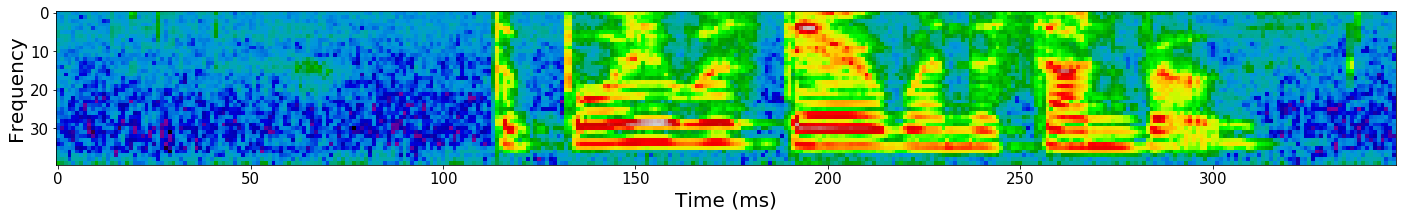

In [17]:
## show the spectrogram of the signal
plot_filter_banks = filter_banks.T
plt.figure(figsize=(24, 6))
plt.imshow(np.flip(plot_filter_banks, axis=0), cmap='nipy_spectral')
plt.xlabel('Time (ms)', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Frequency', fontsize=20)
plt.grid(False)
plt.show()

### MFCC
#### Discrete Cosine Transform (DCT)
#### decorrelate filter bank coefficient

In [63]:
## apply the discret cosine transform
num_ceps = 12
mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)]

In [64]:
(nframes, ncoeff) = mfcc.shape
n = np.arange(ncoeff)
lift = 1 + (ncoeff / 2) * np.sin(np.pi * n / ncoeff)
mfcc *= lift ##

In [65]:
mfcc.shape

(348, 12)

In [66]:
plot_mfcc = mfcc.T
plot_mfcc = np.delete(plot_mfcc, np.s_[200:], axis=1)
print(plot_mfcc.shape)

(12, 200)


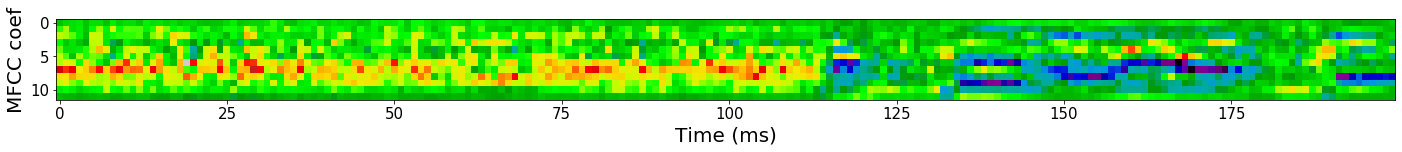

In [67]:
#### show the spectrogram of the signal
#plot_mfcc = mfcc.T
#plot_mfcc = plot_mfcc
plt.figure(figsize=(24, 6))
plt.imshow(np.flip(plot_mfcc, axis=0), cmap='nipy_spectral')
plt.xlabel('Time (ms)', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('MFCC coef', fontsize=20)
plt.grid(False)
plt.show()

In [68]:
## mean normalization of the filter banks
filter_banks -= (np.mean(filter_banks, axis=0) + 1e-8)

In [69]:
## mean normalization of the mfcc
mfcc -= (np.mean(mfcc, axis=0) + 1e-8)

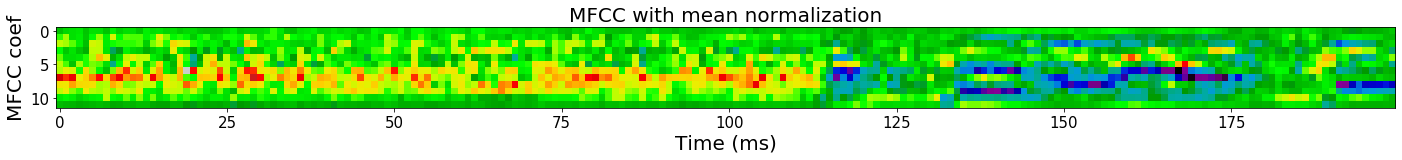

In [73]:
## plot the normalized of 
plot_mfcc = mfcc.T
plot_mfcc = np.delete(plot_mfcc, np.s_[200:], axis=1)
plt.figure(figsize=(24, 6))
plt.imshow(np.flip(plot_mfcc, axis=0), cmap='nipy_spectral')
plt.title('MFCC with mean normalization', fontsize=20)
plt.xlabel('Time (ms)', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('MFCC coef', fontsize=20)
plt.grid(False)
plt.show()

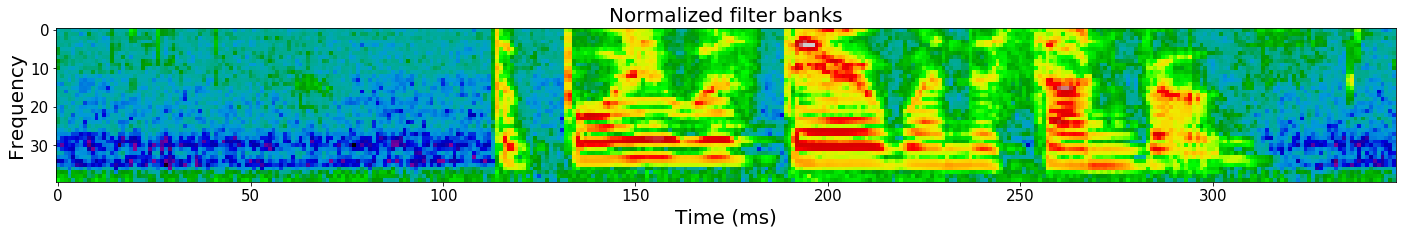

In [75]:
## plot normalized filter banks
## show the spectrogram of the signal
plot_filter_banks = filter_banks.T
plt.figure(figsize=(24, 6))
plt.imshow(np.flip(plot_filter_banks, axis=0), cmap='nipy_spectral')
plt.title('Normalized filter banks', fontsize=20)
plt.xlabel('Time (ms)', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Frequency', fontsize=20)
plt.grid(False)
plt.show()